# Introduction to XGBoost
In this tutorial we are going to explore an open-source software library on python called XGBoost. XGBoost is short for "Extreme Gradient Boosting", it is an optimized distributed gradient boosting library based on the original model in Friedman's paper *Greedy Function Approximation: A Gradient Boosting Machine* you can learn more about the model from [here](http://homes.cs.washington.edu/~tqchen/pdf/BoostedTree.pdf). XGBoost provides a parallel tree boosting(also known as GBDT, GBM) that solve many data science problems in a fast and accurate way. XGBoost aims to provide a "Scalable, Portable and Distributed Gradient Boosting (GBM, GBRT, GBDT) Library" and supports many distributed processing frameworks such as Apache Hadoop and Spark.  

XGBoost is used for supervised learning problems, where we use the training data (with multiple features) to predict a target variable. It is built based on the Gradient Boosting Tree. To explain the theory in a simple way, you can consider it an efficient way to do tree ensembles, where the final prediction for a given example is the sum of predictions from each tree. Usually it takes a lot of time to do tree ensembles by iterating all the trees each time, but GBT will select trees according to the best trees of last step using gradient algorithm. Here is a brief [introduction](http://xgboost.readthedocs.io/en/latest/model.html) to the theory based of XGBoost, and the [paper](https://arxiv.org/pdf/1603.02754v3.pdf) by Tianqi Chen.

Here is the [official site](http://xgboost.readthedocs.io/en/latest/model.html) and [github](https://github.com/dmlc/xgboost) link if you want to know more about XGBoost.




# Theory
Before we start playing with XGBoost, we need to first look at the theories behind. The most important machine learning concept to understand XGBoost better is tree ensemble and gradient boosting. (Note: this part is mostly reference to the paper and [lecture](http://homes.cs.washington.edu/~tqchen/data/pdf/BoostedTree.pdf) by Tianqi Chen).

## Regression Tree and Ensemble 
Regression tree and decision tree are basically the same, except that in each leaf node, regression tree produces hypothesis h as a real value instead of probabilities. Usually a single tree cannot generate very good result, so we need to combine multiple trees and ensemble them to generate a better classifier. The figure shows how two trees are ensembled. The model and the objective function can be written as follows, where K is the number of trees, f is a function in the functional space $\mathcal{F}$, and $\mathcal{F}$ is the set of all possible CARTs, here we are learning f instead of $\Theta$, and you can think f as tree that we can represent using parameters, i.e., the parameter here including the information of the structure of each tree, $\Theta = \{f_1,f_2,...,f_K\}$:   
<center>$\hat{y_i} = \sum_{k=1}^K f_k(x_i),  f_k \in \mathcal{F}$</center>  
<center>$obj(\theta) = \sum_{i=1}^n l(y_i,\hat{y_i}) + \sum_{k=1}^K\Omega(f_k)$</center>  
Notice that $\sum_{i=1}^n l(y_i,\hat{y_i})$ is the training loss and $\sum_{k=1}^K\Omega(f_k)$ is the regularization term.
![Tree ensemble example from http://xgboost.readthedocs.io/ ](https://raw.githubusercontent.com/dmlc/web-data/master/xgboost/model/twocart.png)

## Gradient Boosting

So now we have the objective function, but how we going to learn? Notice here we cannot use Gradient Descent to find the optimal f, because f are trees. One approach is to use boosting. Boosting is the idea of taking several weak learners and turning them into a a strong learner. It is also one of the most sophisticated ensemble techniques and you can learn more from [here](http://homes.cs.washington.edu/~tqchen/data/pdf/BoostedTree.pdf).  With boosting, we can derive the prediction function at t round as follows, where we add a new tree at a time: <center>$\hat{y_i}^{(t)} = \hat{y_i}^{(t-1)} + f_t (x_i)$</center>  
and the objective function at t round becomes follows and we want to find $f_t$ to minimize the $obj^{(t)}$.
<center>$obj^{(t)} = \sum_{i=1}^n l(y_i,\hat{y_i}^{(t)}) + \sum_{i=1}^{t}\Omega(f_i) = \sum_{i=1}^n l(y_i,\hat{y_i}^{(t-1)} + f_t(x_i)) + \Omega(f_t) + c $</center>  
XGBoost used gradient boost approach where take the gradient of loss function $g_i = \partial_{\hat{y}^{(t-1)}}$ $l(y_i,\hat{y}^{(t-1)})$ and $h_i = \partial_{\hat{y}^{(t-1)}}^2$ $l(y_i,\hat{y}^{(t-1)})$ at each iteration, for how $g_i$ and $h_i$ is calculated, and greedily grow a tree that can reduce the loss at max, here I will not include the mathmatical details for gradient boosting, if you are interested in how g and h calculated, you can refer to the detailed mathematical calculation [here](http://homes.cs.washington.edu/~tqchen/data/pdf/BoostedTree.pdf).

Here we can try using scikit learn to implement single decision tree classifier and a gradient boost classifer to see how they perform on the Iris dataset.

In [3]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import cross_validation
from sklearn import datasets
import numpy as np
import xgboost as xgb
import pandas as pd
from sklearn.grid_search import GridSearchCV

In [4]:
#Here we use sklearn iris dataset 
iris = datasets.load_iris()
X, y = iris.data[:, 1:3], iris.target
train_x, train_y = X[:120], y[:120]
test_x, test_y = X[120:], y[120:]
print X[:10],y[:10]

[[ 3.5  1.4]
 [ 3.   1.4]
 [ 3.2  1.3]
 [ 3.1  1.5]
 [ 3.6  1.4]
 [ 3.9  1.7]
 [ 3.4  1.4]
 [ 3.4  1.5]
 [ 2.9  1.4]
 [ 3.1  1.5]] [0 0 0 0 0 0 0 0 0 0]


### Single Decision Tree Implementation Using Scikit-learn

In [5]:
single_tree_clf = DecisionTreeClassifier()
results = cross_validation.cross_val_score(single_tree_clf, X, y, cv=4)
print("Cross validation result: %.4f" % results.mean())

#train model
single_tree_clf.fit(train_x, train_y)
#predict
single_tree_pred = single_tree_clf.predict(test_x)

#result
accuracy = sum(single_tree_pred == test_y)*1.0/len(single_tree_pred)
print("Single Decision Tree Accuracy: %.4f" % accuracy)
print("Single Decision Tree Node    : %d" % single_tree_clf.tree_.node_count)

Cross validation result: 0.9140
Single Decision Tree Accuracy: 0.8000
Single Decision Tree Node    : 21


### Gradient boost Implementation Using Scikit-learn

In [6]:
#Gradient boost use 100 trees
num_trees = 100
#Initiate GBC object
gbc = GradientBoostingClassifier(n_estimators=num_trees, random_state=5)
#Use cross validation to see the result
results = cross_validation.cross_val_score(gbc, train_x, train_y, cv=4)
print("Cross validation result: %.4f" % results.mean())
gbc.fit(train_x, train_y)
Gradient_Boost_prd = gbc.predict(test_x)
accuracy = sum(Gradient_Boost_prd == test_y)*1.0/len(Gradient_Boost_prd)
print("Gradient Boost Tree Accuracy: %.4f" % accuracy)

Cross validation result: 0.9580
Gradient Boost Tree Accuracy: 0.8333


# Practice
At above we used scikit-learn GradientBoostingClassifier, but XGBoost typically faster than scikit-learn especially in large dataset, the reason you can reference to this [post](http://stats.stackexchange.com/questions/202858/loss-function-approximation-with-taylor-expansion/204377), it explains how XGBoost is different from traditional gradient boost algorithm thus achieving a faster approach for GBT. Now let's learn how to use XGBoost by walkthrough a simple use case.

## Install and run your XGBoost
For mac and linux, you can simply use anaconda to install XGBoost by simply run the following command (Note: This tutorial used an old version for the convenience to install):  
 > <pre><code>conda install -c aterrel xgboost=0.4.0</code></pre>  
 
If you want to install on your own, here is a quick [guide](https://xgboost.readthedocs.io/en/latest///build.html) for your.

In [45]:
import numpy as np
import xgboost as xgb
import pandas as pd
from sklearn.grid_search import GridSearchCV
from mpl_toolkits.basemap import Basemap

## Prepare your data
XGBoot used DMatrix object as its data type, you have several ways to convert your data to DMatrix:

### 1. Load from libsvm text file
<pre><code>traind = xgb.DMatrix('yourfilename.txt')</code></pre>  

### 2. Load from binary buffer generated by xgboost
<pre><code>testd = xgb.DMatrix('test.svm.buffer')</code></pre>  

### 3. Convert from numpy arrays
We can create a dataset with 3 entries and each contains 10 features, and also a label numpy array, and convert them to a DMatrix.
<pre><code>data = np.random.rand(3,10) # 3 entities, each contains 10 features
label = np.random.randint(2, size=3) # binary label
traind = xgb.DMatrix( data, label=label) # create DMatrix</code></pre> 

### 4. Convert from scipy.sparse matrix
<pre><code>csr = scipy.sparse.csr_matrix((dat, (row,col)))
traind = xgb.DMatrix(csr, label = labels)</code></pre> 

In the first step, we will do some basic cleanning to the raw data, filter out those data with NA field and convert them into DMatrix. Note that you can also give weight to your samples and process the missing value in DMatrix by this way:  
<pre><code>wht = np.random.rand(3,1)  
dtrain = xgb.DMatrix( data, label=label, missing = -999.0, weight=wht)</code></pre>

### 5. Save your DMatrix
You can also save save dmatrix into binary buffer: 
<pre><code>testd.save_binary('dtest.buffer')</code></pre>

### Dataset info
In this tutorial we will first use Breast Cancer Wisconsin (Diagnostic) Data Set, and our task is to make diagnosis for malignant and benign (M = malignant, B = benign). You can find more information about the dataset from [here](https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+%28Diagnostic%29), the provided data is in csv format, you will need to process the data first, using the first 400 rows as the training dataset and remaining 169 as the test dataset. The column attributes are listed here:
Attribute Information:

1) ID number 2) Diagnosis (M = malignant, B = benign) 3-32)

Ten real-valued features are computed for each cell nucleus:

a) radius (mean of distances from center to points on the perimeter) 
b) texture (standard deviation of gray-scale values)  
c) perimeter  
d) area  
e) smoothness (local variation in radius lengths)  
f) compactness (perimeter^2 / area - 1.0)  
g) concavity (severity of concave portions of the contour)  
h) concave points (number of concave portions of the contour)  
i) symmetry  
j) fractal dimension ("coastline approximation" - 1)  


In [46]:
#Load csv 
data = pd.read_csv('data.csv')
print data.columns

Index([u'id', u'diagnosis', u'radius_mean', u'texture_mean', u'perimeter_mean',
       u'area_mean', u'smoothness_mean', u'compactness_mean',
       u'concavity_mean', u'concave points_mean', u'symmetry_mean',
       u'fractal_dimension_mean', u'radius_se', u'texture_se', u'perimeter_se',
       u'area_se', u'smoothness_se', u'compactness_se', u'concavity_se',
       u'concave points_se', u'symmetry_se', u'fractal_dimension_se',
       u'radius_worst', u'texture_worst', u'perimeter_worst', u'area_worst',
       u'smoothness_worst', u'compactness_worst', u'concavity_worst',
       u'concave points_worst', u'symmetry_worst', u'fractal_dimension_worst',
       u'Unnamed: 32'],
      dtype='object')


You will implement the following method to get your training and test dataset:
1. Make all your columns numeric since xgboost only works for numerics
2. Split original dataset to training dataset and test dataset
3. Separate your label column out off your training/test dataset
4. Convert your dataset to DMatrix

In [47]:
def splitData(data):
    data['diagnosis'] = data['diagnosis'].apply(lambda x:x=='B')*1
    data = data.iloc[:,:32]
    train = data.iloc[:400,:]
    test = data.iloc[400:,:]
    y_train = train.pop('diagnosis')
    y_test = test.pop('diagnosis')
    xgdmat = xgb.DMatrix(train, y_train)
    xgdtest = xgb.DMatrix(test, y_test)
    return (xgdmat,xgdtest,train,y_train,test,y_test)
    """
    Input: data<pandas.core.frame.DataFrame>: data loaded 
    In this method you will need to implement the data processing as stated above
       return the following
       1.xgdtrain<xgboost.DMatrix>: DMatrix object for your training dataset
       2.xgdtest<xgboost.DMatrix>: DMatrix object for your testing dataset
       3.training set X <class 'pandas.core.frame.DataFrame'>
       4.label of training set<Series>
       5.test set X <class 'pandas.core.frame.DataFrame'>
       6.label of testing set<Series>
    """

In [48]:
(xgdtrain, xgdtest, x_train, y_train, x_test, y_test) = splitData(data)
print xgdtrain
print xgdtest
print x_train.shape
print y_train.shape
print x_test.shape
print y_test.shape

(400, 31)
(400,)
(169, 31)
(169,)


# Parameters
Before we train our model, XGBoot provides us the options to set different parameters, you can see for detailed [documentation](https://github.com/dmlc/xgboost/blob/master/doc/parameter.md). Here are examples of how to set parameters using XGBoot:  
<pre><code>param = {'max_depth':2, 'eta':1, 'silent':1, 'objective':'binary:logistic' }
param['nthread'] = 4
plst = param.items()
plst += [('eval_metric', 'auc')] # Multiple evals can be handled in this way
plst += [('eval_metric', 'ams@0')]</code></pre>
In more advanced xgboost version, you can also specify validations set to watch performance:
<pre><code>watchlist  = [(dtest,'eval'), (dtrain,'train')]</code></pre>


In [49]:
params = {'max_depth':3, 'eta':1, 'silent':1, 'objective':'binary:logistic' }
print params

{'objective': 'binary:logistic', 'eta': 1, 'max_depth': 3, 'silent': 1}


# Tuning your parameters
Here we are using grid search to see which combination of parameters can give us a better result. Here are the [guide](http://xgboost.readthedocs.io/en/latest/how_to/param_tuning.html) for how to tuning your parameters.

In [50]:
#cv_prms are the parameters you are going to make grid search
#init_prms are the parameters you set fixed
cv_prms = {'learning_rate': [1, 0.1], 'min_child_weight': [1,2,3]}
init_prms = {'n_estimators': 1000, 'seed':0,'objective': 'binary:logistic' }

optimized_GBM = GridSearchCV(xgb.XGBClassifier(**init_prms), 
                            cv_prms, 
                             scoring = 'accuracy', cv = 5, n_jobs = -1)
optimized_GBM.fit(x_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, colsample_bytree=1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=3, min_child_weight=1,
       n_estimators=1000, nthread=-1, objective='binary:logistic', seed=0,
       silent=True, subsample=1),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'learning_rate': [1, 0.1], 'min_child_weight': [1, 2, 3]},
       pre_dispatch='2*n_jobs', refit=True, scoring='accuracy', verbose=0)

In [51]:
optimized_GBM.grid_scores_

[mean: 0.95500, std: 0.02134, params: {'learning_rate': 1, 'min_child_weight': 1},
 mean: 0.94750, std: 0.02362, params: {'learning_rate': 1, 'min_child_weight': 2},
 mean: 0.95500, std: 0.02751, params: {'learning_rate': 1, 'min_child_weight': 3},
 mean: 0.96250, std: 0.01728, params: {'learning_rate': 0.1, 'min_child_weight': 1},
 mean: 0.96250, std: 0.02051, params: {'learning_rate': 0.1, 'min_child_weight': 2},
 mean: 0.95750, std: 0.01990, params: {'learning_rate': 0.1, 'min_child_weight': 3}]

In [52]:
#After seen the best result, we decided to use parameters with best result
params = {'max_depth':3, 'eta':0.1, 'min_child_weight': 2, 'silent':1, 'objective':'binary:logistic' }
print params

{'objective': 'binary:logistic', 'eta': 0.1, 'max_depth': 3, 'min_child_weight': 2, 'silent': 1}


# Train your model

Once we have our data and the parameters we can train our model, you can simply use xgb.train
<pre><code>bst = xgb.train(param, dtrain, num_round=2, watchlist)</code></pre>  
Save model  
<pre><code>bst.save_model('xgbm.model')</code></pre>
Dump model
<pre><code>bst.dump_model('dump.raw.txt')</code></pre>
Dump model with feature map
<pre><code>bst.dump_model('dump.raw.txt','featmap.txt')</code></pre>
You can use the booster to If retrieve the model you saved:
<pre><code>bst2 = xgb.Booster(model_file='xgbm.model')</code></pre>

In [53]:
def trainModel(params, xgdmat, num_boost_round = 300):
    gb = xgb.train(params, xgdmat, num_boost_round)
    #gb.save_model('xgbm.model')
    #gb.dump_model('dump.raw.txt','featmap.txt')
    return gb
    """Input: 
    params: parameters for training model
    xgdmat: training set data generated previously
    num_boost_round: number of iterations
    Return:
    model<class 'xgboost.Booster'>
    """

You can also see which features were most important in the series of trees:

In [54]:
gb = trainModel(params, xgdtrain)
importances = gb.get_fscore()
print importances

{'f0': 14, 'f2': 33, 'f4': 2, 'f5': 17, 'f6': 2, 'f7': 2, 'f8': 37, 'f9': 22, 'f23': 31, 'f22': 54, 'f21': 11, 'f20': 7, 'f27': 27, 'f26': 1, 'f25': 37, 'f24': 43, 'f29': 26, 'f28': 24, 'f30': 4, 'f18': 21, 'f19': 25, 'f12': 5, 'f13': 15, 'f11': 6, 'f16': 22, 'f17': 12, 'f14': 34, 'f15': 4}


# Predict 
Using the following code to predict, examples are like:
<pre><code>pred = bst.predict(yourtestDmatrix)</code></pre>

In [55]:
def predict_xgb(gb,xgdtest):
    y_pred = gb.predict(xgdtest)
    return y_pred
    """
    Input: 
    gb: your model built previously
    xdgtest: your test set
    Implement this method to predict on your test data, return the labeled result
    return: y_pred <Series>
    """

In [56]:
y_pred = predict_xgb(gb,xgdtest)
y_pred[y_pred <= 0.5] = 0
y_pred[y_pred > 0.5] = 1
print y_pred

[ 0.  1.  1.  1.  1.  1.  1.  1.  0.  1.  1.  1.  1.  0.  0.  1.  1.  0.
  1.  1.  1.  0.  1.  1.  1.  1.  1.  1.  1.  1.  0.  1.  0.  0.  1.  0.
  1.  1.  1.  1.  1.  0.  1.  1.  0.  1.  0.  1.  1.  0.  1.  0.  1.  1.
  1.  1.  1.  1.  1.  1.  0.  0.  1.  1.  1.  1.  1.  1.  0.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  0.  1.  1.  1.  1.  1.  1.  1.  0.  1.  0.
  1.  0.  0.  1.  1.  1.  1.  1.  0.  0.  1.  0.  1.  0.  1.  1.  1.  1.
  1.  0.  1.  1.  0.  1.  0.  1.  0.  0.  1.  1.  1.  0.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  0.  1.  0.  0.  1.  1.  1.  1.  0.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  0.  0.  0.  0.  0.  0.  1.]


# Evaluate your result

Now we have predicted, you can also evaluate your model by printing out the error rate. Remember to convert y_pred to the actual label. For this test, I got MSE of 0.023668639053254437 and accuracy of 0.97633136094674555.

In [57]:
def cal_error(y_pred, y_test):
    mse = sum((y_pred - y_test)**2)*1.0/y_pred.shape[0]
    accuracy = sum(y_pred == y_test)*1.0/y_pred.shape[0]
    return (mse,accuracy)
    """Calculate your MSE using in this method and return
        mse <float>
        accuracy <float>
    """

In [58]:
print cal_error(y_pred,y_test)

(0.023668639053254437, 0.97633136094674555)


# Putting all together

We have walked through the process of XGBoost use case of malignant diagnosis. Now we are going to use XGBoost on some interesting data and see how it performs. In this part we will combine what we have learnt in the walkthrough session, and apply XGBoost to a multiclass classification problem. We are going to use the dataset of [Pokemon historical appearance](https://www.kaggle.com/semioniy/predictemall) to predict when a [rare](http://www.pokego.org/rare-pokemon-list/) pokemon will appear (at time of the day night, evening, afternoon, morning). The complete dataset includes 209 features and 296021 records, in this example we will divide the data into training set and test set for convenient.

In [101]:
data = pd.read_csv('300k.csv')
print data.columns

Index([u'pokemonId', u'latitude', u'longitude', u'appearedLocalTime', u'_id',
       u'cellId_90m', u'cellId_180m', u'cellId_370m', u'cellId_730m',
       u'cellId_1460m',
       ...
       u'cooc_143', u'cooc_144', u'cooc_145', u'cooc_146', u'cooc_147',
       u'cooc_148', u'cooc_149', u'cooc_150', u'cooc_151', u'class'],
      dtype='object', length=208)


In [36]:
#here is the set of rare pokemonId used to extract the dataset we need
rareid = set([88,89,106,107,108,113,129,130,137,142,83,132,144,145,146,150,151,115,122,131])

In [103]:
def processData(data, rareid):
    #drop na rows
    data = data.dropna()
    #Select features
    col = ['pokemonId','latitude','longitude','gymDistanceKm','pokestopDistanceKm','population_density','urban','suburban','midurban','rural',
'appearedTimeOfDay','appearedDayOfWeek','terrainType','closeToWater','city','continent','weather']
    data['israre'] = data['pokemonId'].isin(rareid)*1
    rare = data[data['israre'] == 1]
    rare = rare[col]
    #Convert categorical data to numerical
    for feature in rare.columns:
        if rare[feature].dtype == 'object':
            rare[feature] = pd.Categorical(rare[feature]).codes
        if rare[feature].dtype == 'bool':
            rare[feature] = rare[feature]*1
    #split 2/3 to training set 1/3 to test set
    n = 2*rare.shape[0]/3
    train_x = rare[:n]
    test_x = rare[n:]
    train_y = train_x.pop('appearedTimeOfDay')
    test_y = test_x.pop('appearedTimeOfDay')
    train_dmx = xgb.DMatrix(train_x, train_y)
    test_dmx = xgb.DMatrix(test_x, test_y)
    return (rare, train_x, train_y, train_dmx, test_x, test_y, test_dmx)

In [104]:
(rare, train_x, train_y, train_dmx, test_x, test_y, test_dmx) = processData(data, rareid)
print (train_dmx, test_dmx)

(<xgboost.DMatrix object at 0x127b6ad90>, <xgboost.DMatrix object at 0x127b6a050>)


It's always fun to explore the dataset, let's plot pokemon position and the rare pokemon position on the map to see how it looks like. Seems Europe is more likely to have rare pokemon appear.

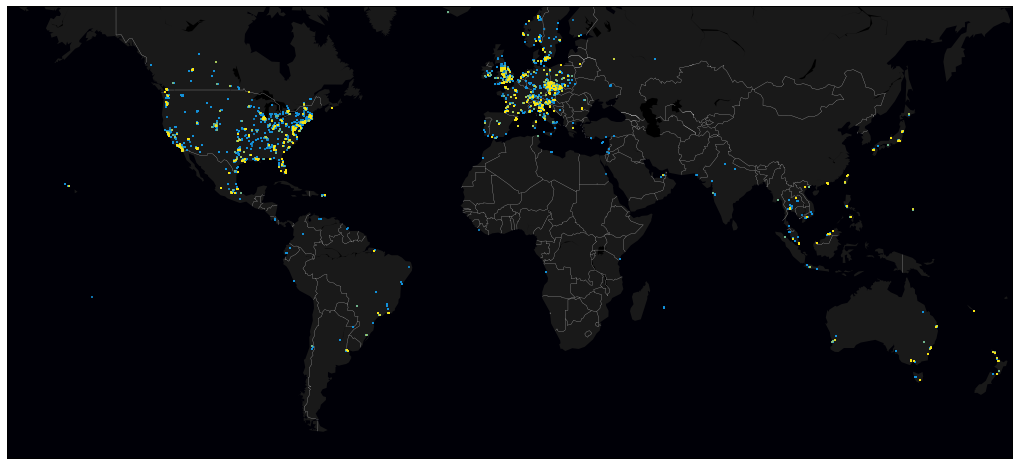

In [117]:
plt.figure(1, figsize=(18,9))
m = Basemap(projection='merc',
             llcrnrlat=-60,
             urcrnrlat=65,
             llcrnrlon=-180,
             urcrnrlon=180,
             lat_ts=0,
             resolution='c')
m.fillcontinents(color='#191919',lake_color='#000000')
m.drawmapboundary(fill_color='#000007') 
m.drawcountries(linewidth=0.2, color="w")

# Plot map
x1, y1 = m(data.longitude.tolist(),data.latitude.tolist())
x2, y2 = m(rare.longitude.tolist(),rare.latitude.tolist())
m.scatter(x1,y1, s=4, c="#1292db", lw=0, alpha=1, zorder=5)
m.scatter(x2,y2, s=2, c="#fde711", lw=0, alpha=1, zorder=5)
plt.show()

In [87]:
#Set up parameters to multi:softprob for multiclass
cus_param = {'eta': 0.1, 'num_class': 4, 'objective': 'multi:softmax'}
print cus_param

{'objective': 'multi:softmax', 'eta': 0.1, 'num_class': 4}


In [88]:
#Print out importances
cus_gb = trainModel(cus_param, train_dmx)
cus_impor = cus_gb.get_fscore()
dt = dict(enumerate(train_x.columns))
print cus_impor

{'f0': 361, 'f1': 4940, 'f2': 5424, 'f3': 4178, 'f4': 5126, 'f5': 3465, 'f12': 223, 'f13': 1382, 'f10': 2271, 'f11': 1012, 'f14': 137, 'f15': 2117}


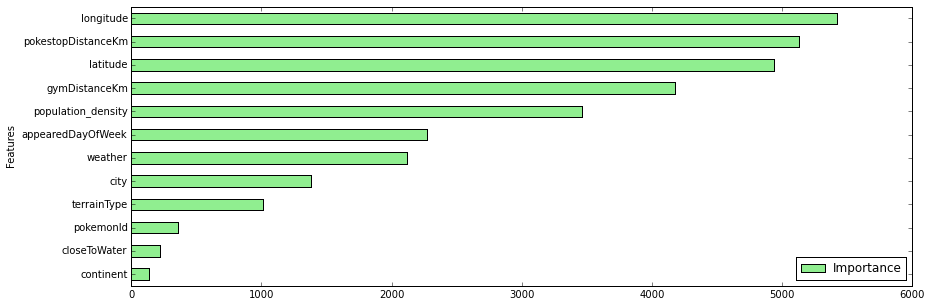

In [118]:
#Plot out importances
%matplotlib inline
frame = pd.DataFrame({'Importance': list(cus_impor.values()), 'Features': [dt[int(key[1:])] for key in cus_impor.keys()]})
frame.sort_values(by = 'Importance', inplace = True)
frame.plot(kind = 'barh', x = 'Features', figsize = (14,5), color = 'lightgreen')

In [94]:
#predict and get result
yla = predict_xgb(cus_gb, train_dmx)
print yla
print ('Predict 0: %d Predict 1: %d Predict 2: %d Predict 3: %d'%(sum(yla == 0),sum(yla == 1), sum(yla == 2),sum(yla == 3)))
print ('Testset 0: %d Testset 1: %d Testset 2: %d Testset 3: %d'%(sum(train_y == 0),sum(train_y == 1), sum(train_y == 2),sum(train_y == 3)))
print ('Accuracy for training: %0.4f'% (sum(yla == train_y)*1.0/len(yla)))
ylabel = predict_xgb(cus_gb,test_dmx)
print ylabel
print ('Predict 0: %d Predict 1: %d Predict 2: %d Predict 3: %d'%(sum(ylabel == 0),sum(ylabel == 1), sum(ylabel == 2),sum(ylabel == 3)))
print ('Testset 0: %d Testset 1: %d Testset 2: %d Testset 3: %d'%(sum(test_y == 0),sum(test_y == 1), sum(test_y == 2),sum(test_y == 3)))
print ('Accuracy for testing: %0.4f'% (sum(ylabel == test_y)*1.0/len(ylabel)))

[ 3.  3.  3. ...,  3.  1.  1.]
Predict 0: 990 Predict 1: 784 Predict 2: 1042 Predict 3: 2986
Testset 0: 980 Testset 1: 862 Testset 2: 1072 Testset 3: 2888
Accuracy for training: 0.9557
[ 3.  1.  1. ...,  3.  1.  3.]
Predict 0: 0 Predict 1: 211 Predict 2: 0 Predict 3: 2690
Testset 0: 504 Testset 1: 587 Testset 2: 752 Testset 3: 1058
Accuracy for testing: 0.3995


As we can see, using XGBoost we only predict 39.95% right when using test data in this particular multiclass problem, and we also see there is an serious overfiting problem here. The main reason for low accuracy might be the fact that the time when rare pokemon comming out during the day is randomly generated, so it's hard to obtain a reasonable outcome for this question, and we can see XGBoost is not always performing well on this kind of dataset. But this example is just a interesting practice on the usage of XGBoost on multiclass problem, hopefully we learnt how to use it and can apply to some other real problems and get a better result.

At last, what I want to mention is that the tutorial is just simple usage of XGBoost library, and is not focus on the machine learning algorithms behind it. Gradient boost tree itself is a very interesting topic and if you want to dig more about Gradient Boosting Tree and theory behind XGBoost, you can check link from [here](http://www.d.umn.edu/~rmaclin/publications/opitz-jair99.pdf). 